# FPGA Equalizer Simulation

For testing and aiding in the design of the DSP portions of the FPGA Equalizer 

In [1]:
from scipy import signal
import math
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

## Variables and constants

In [2]:
# user defined parameters
filter_count = 6
Fs = 48000
write_audio_files_float = False
write_audio_files_fixed = True
audio_length_sec = 10
adc_bit_length = 12
processing_bit_length = 16
accumulate_bit_length = 32
filter_amp_float = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

# variables
filter_sizes = np.zeros(filter_count, dtype=int)
filter_max_values = np.zeros(filter_count, dtype=float)
filter_min_values = np.zeros(filter_count, dtype=float)
filter_taps = []
filter_taps_fixed = []
filter_amp_fixed = []

## Retrieve filter coefficients from files

In [3]:
# read filter taps from text file
for index in range(filter_count) :
    file_name = "filter{}_taps.txt".format(index+1)
    file = open(file_name, "r")
    text = file.readlines()
    filter_sizes[index] = int(text[0][1:])
    taps = np.array([float(element) for element in text[1:]])
    taps_size_check = len(taps)
    if (taps_size_check != filter_sizes[index]) :
        print("Error: sizes don't match up!")
        print("Defined filter size:", filter_sizes[index])
        print("Actual filter size:", taps_size_check)
    filter_max_values[index] = np.amax(taps)
    filter_min_values[index] = np.amin(taps)
    filter_taps.append(taps)
    file.close()
    
    # print results
    print("Filter{} Size:".format(index+1), filter_sizes[index], "taps")
    print("Filter{} Maximum Tap Value:".format(index+1), filter_max_values[index])
    print("Filter{} Minimum Tap Value:".format(index+1), filter_min_values[index])
    print("")

Filter1 Size: 641 taps
Filter1 Maximum Tap Value: 0.006013577107663439
Filter1 Minimum Tap Value: -0.0050859712862627955

Filter2 Size: 641 taps
Filter2 Maximum Tap Value: 0.011819781301914727
Filter2 Minimum Tap Value: -0.007266119815150642

Filter3 Size: 641 taps
Filter3 Maximum Tap Value: 0.031922914879484475
Filter3 Minimum Tap Value: -0.02044753956519573

Filter4 Size: 641 taps
Filter4 Maximum Tap Value: 0.09479886012948853
Filter4 Minimum Tap Value: -0.061251677462770326

Filter5 Size: 641 taps
Filter5 Maximum Tap Value: 0.28246698064786424
Filter5 Minimum Tap Value: -0.1817898957227501

Filter6 Size: 641 taps
Filter6 Maximum Tap Value: 0.5798626137614905
Filter6 Minimum Tap Value: -0.30834026910834333



# Plot floating point filter frequency characteristics

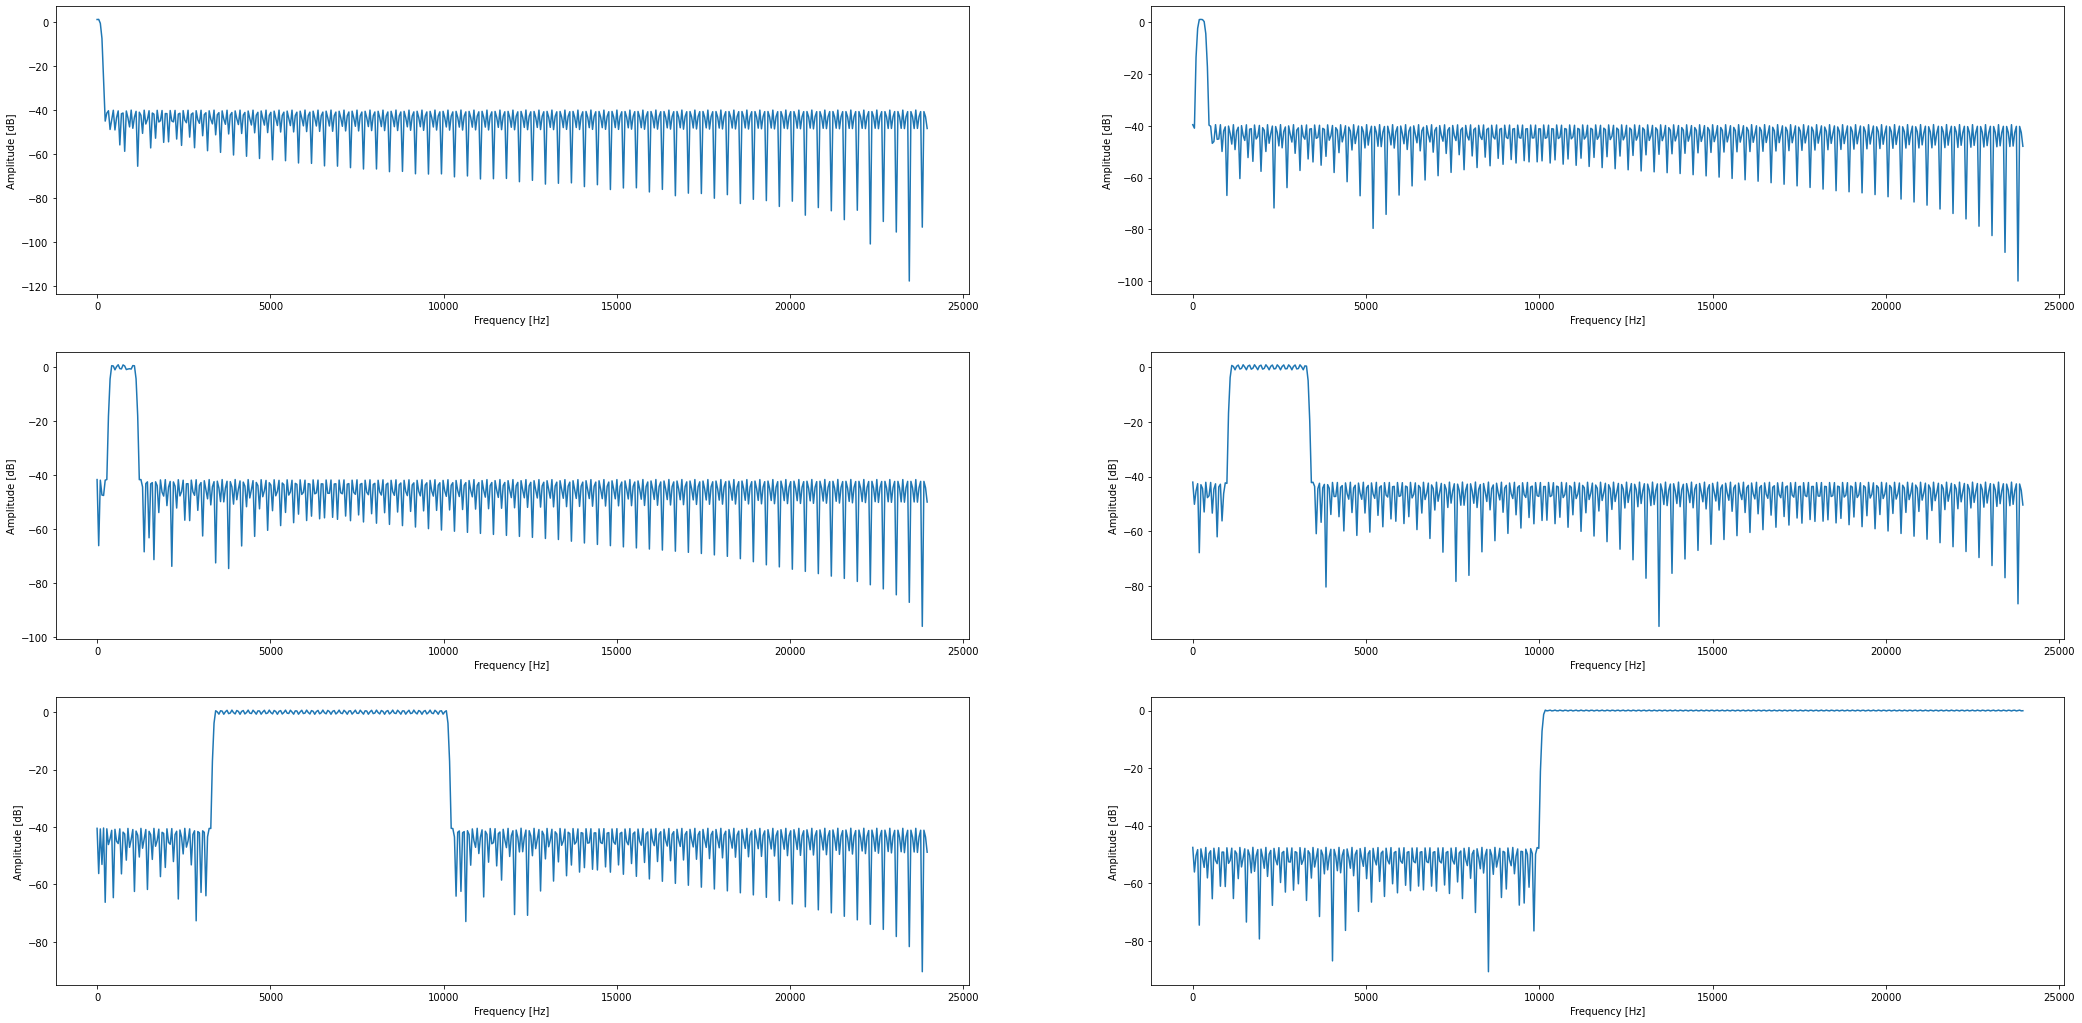

In [4]:
plt.figure(figsize=(6*filter_count, 3*filter_count))
added_taps = np.zeros(np.amax(filter_sizes))
for index in range(filter_count):
    taps = filter_taps[index]

    # get frequency response
    w, H = signal.freqz(taps)
    angles = np.unwrap(np.angle(H))
    w = w * Fs / (2 * np.pi)
    
    # add filters
    added_taps[0:filter_sizes[index]] = added_taps[0:filter_sizes[index]] + taps

    # plot frequency response
    ax = plt.subplot(3, 2, index+1)
    ax.plot(w, 20 * np.log10(abs(H)))
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Amplitude [dB]')

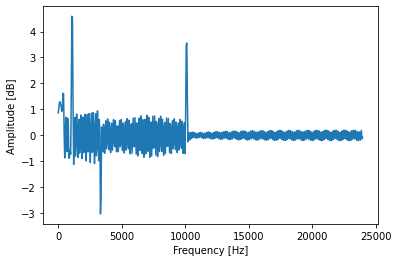

Min. Magnitude: -3.026511192396047
Min. Frequency: 3328.1249999999995
Min. Magnitude: -2.3800576222512353
Min. Frequency: 3375.0
Max. Magnitude: 3.5552470066828183
Max. Frequency: 10125.0
Max. Magnitude: 4.545137107404245
Max. Frequency: 1125.0
Max. Magnitude: 4.5885807467351345
Max. Frequency: 1078.125


In [5]:
# plot added filters
w, H = signal.freqz(added_taps)
angles = np.unwrap(np.angle(H))
w = w * Fs / (2 * np.pi)
H = 20 * np.log10(abs(H))

plt.plot(w, H)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.show()

# check peaks
min_index = np.argpartition(H, 2)[:2]
max_index = np.argpartition(H, -3)[-3:]
for i in min_index:
    print("Min. Magnitude:", H[i])
    print("Min. Frequency:", w[i])
for j in max_index:
    print("Max. Magnitude:", H[j])
    print("Max. Frequency:", w[j])

## Convert values to fixed point

In [6]:
# Find filter quantization coefficients
coeff_max = np.amax(filter_max_values)
fixed_point_max = 2**processing_bit_length - 1
quantizer = int(math.log2(fixed_point_max / coeff_max))
b_q = 2**quantizer
print("Quantized bit length:", quantizer)

# Scale taps and convert to integers
for index in range(filter_count):
    taps = np.array([int(b_q * i) for i in filter_taps[index]])
    filter_taps_fixed.append(taps)
    
# Scale amp values
for index in range(filter_count) :
    i = filter_amp_float[index]
    if (i == 0.0) :
        filter_amp_fixed.append(2**(accumulate_bit_length-1))
    elif (i > 2.0) :
        print("Amp cannot be greater than 2!")
        filter_amp_fixed.append(b_q)
    else :
        filter_amp_fixed.append(int(b_q / i))

Quantized bit length: 16


## Plot fixed point filter frequency characteristics

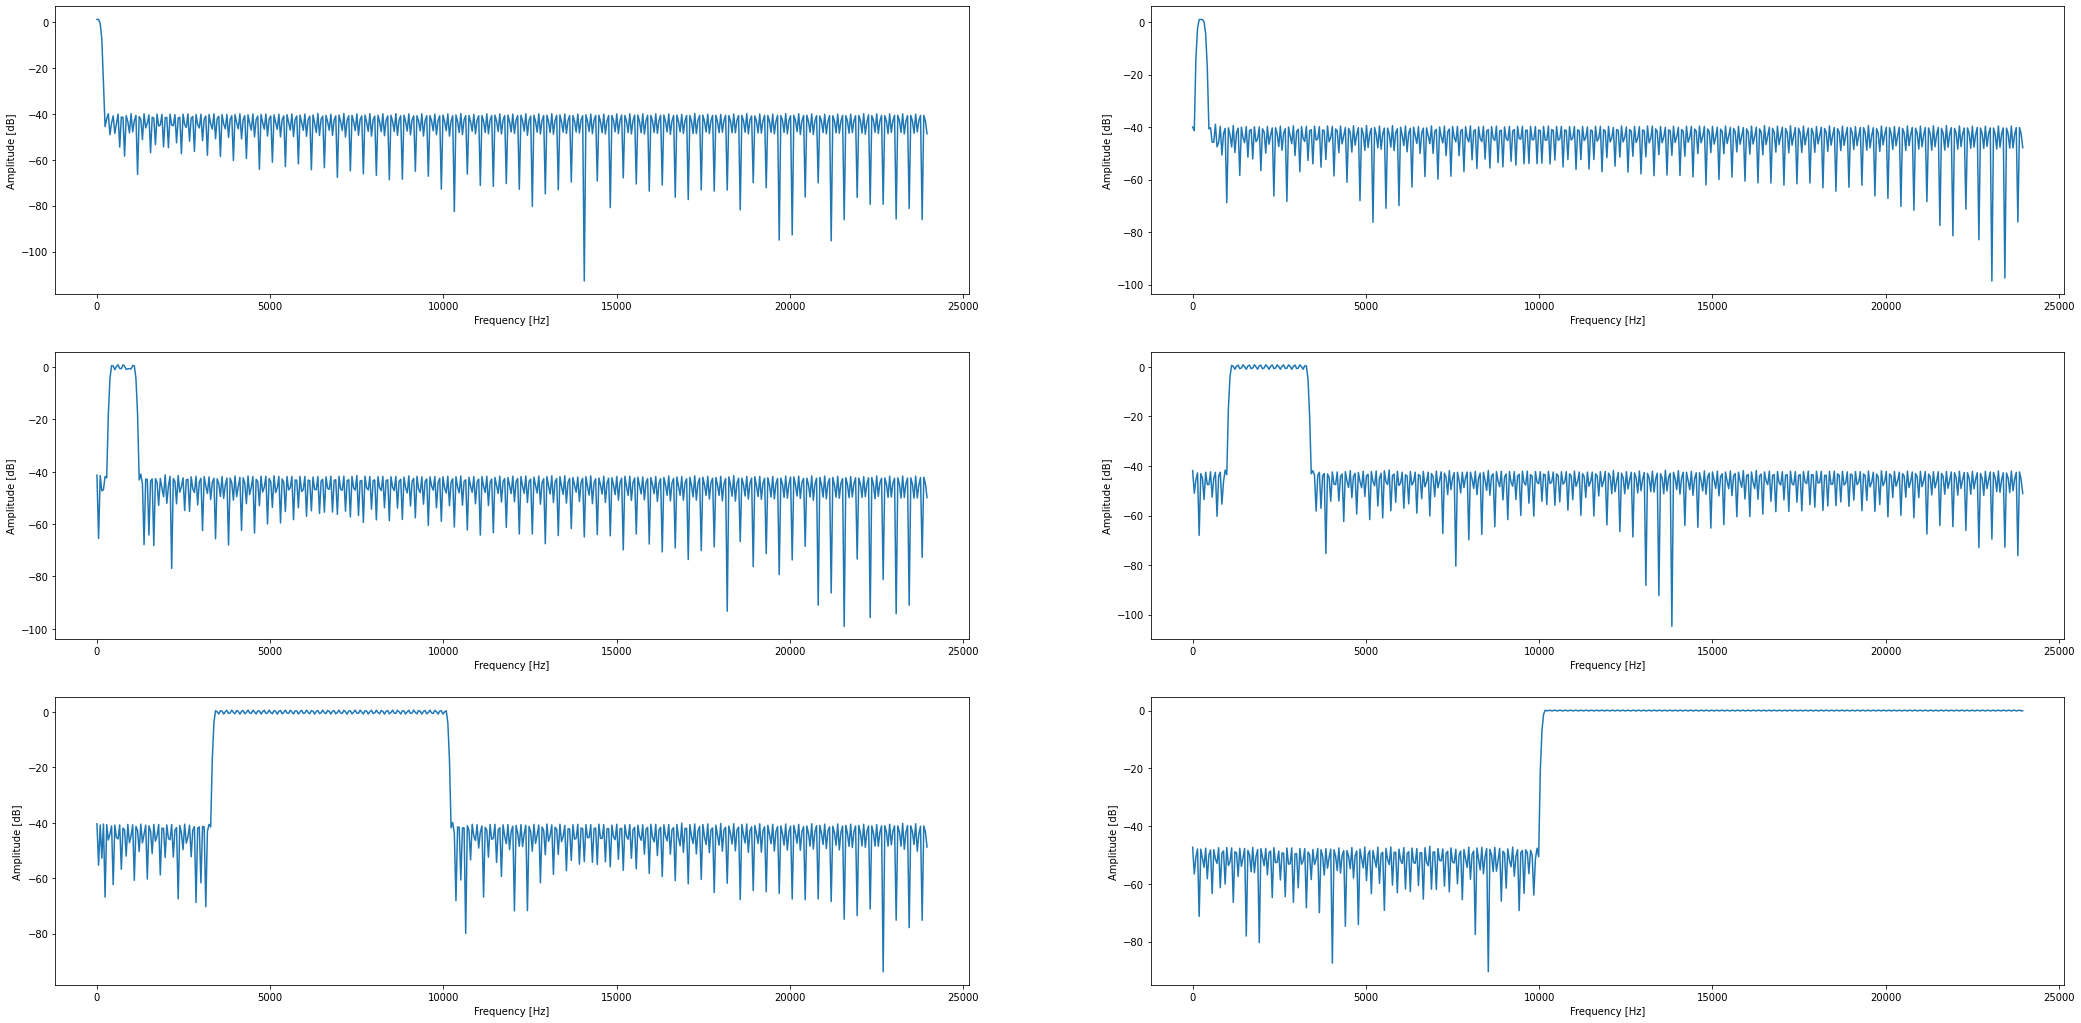

In [7]:
plt.figure(figsize=(6*filter_count, 3*filter_count))
added_taps = np.zeros(np.amax(filter_sizes))
for index in range(filter_count):
    taps = filter_taps_fixed[index] / b_q

    # get frequency response
    w, H = signal.freqz(taps)
    angles = np.unwrap(np.angle(H))
    w = w * Fs / (2 * np.pi)
    
    # add filters
    added_taps[0:filter_sizes[index]] = added_taps[0:filter_sizes[index]] + taps

    # plot frequency response
    ax = plt.subplot(3, 2, index+1)
    ax.plot(w, 20 * np.log10(abs(H)))
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Amplitude [dB]')

## Simulate filters with input audio

In [8]:
# simulate floating point filters
if (write_audio_files_float == True) :
    # get audio
    audio, fs = sf.read('fahey.wav')
    audio_snipped = audio[fs*5:fs*(5+audio_length_sec)]
    x = audio_snipped[:,0]
    equalized_x = np.zeros(np.shape(x))
    
    # plot frequency contents
    f, t, Sxx = signal.spectrogram(x, fs)
    plt.pcolormesh(t, f[:10], Sxx[:10], shading='gouraud')
    plt.title("Input Audio Spectrogram")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    
    # iterate through filters to simulate equalizer
    for index in range(filter_count):
        taps = filter_taps[index]
        
        # filter individual channels
        filtered_audio = filter_amp_float[index] * np.convolve(x, taps, mode='full')
        
        # add to equalized audio channel
        equalized_x = equalized_x + filtered_audio[:len(equalized_x)]
        
        # write filtered audio to wav file
        file_name = "filtered_audio_float{}.wav".format(index+1)
        audio_out = [[i, i] for i in filtered_audio]
        sf.write(file_name, audio_out, fs)
        
        # plot frequency contents
        f, t, Sxx = signal.spectrogram(filtered_audio, fs)
        plt.pcolormesh(t, f[:10], Sxx[:10], shading='gouraud')
        plt.title("Filter{} Spectrogram".format(index+1))
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
        
    # write out equalized input audio
    sf.write("equalized_audio_float.wav", equalized_x, fs)
    
    # plot frequency contents
    f, t, Sxx = signal.spectrogram(equalized_x, fs)
    plt.pcolormesh(t, f[:10], Sxx[:10], shading='gouraud')
    plt.title("Equalized Spectrogram")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()   

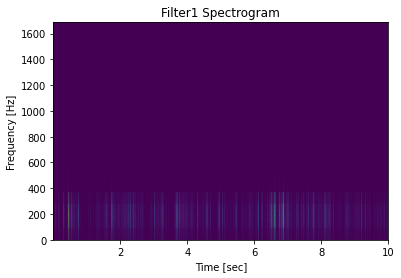

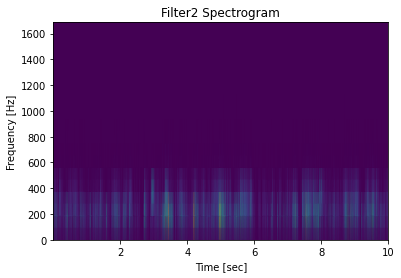

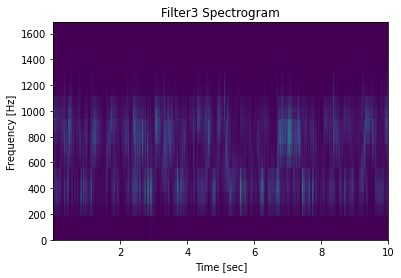

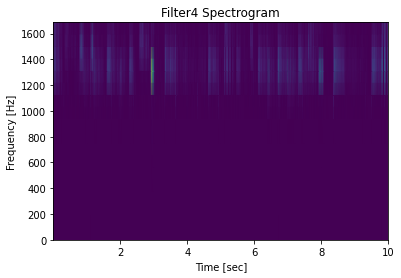

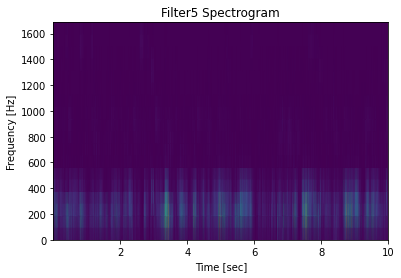

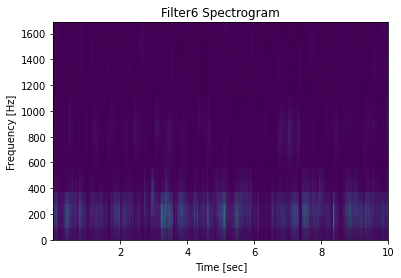

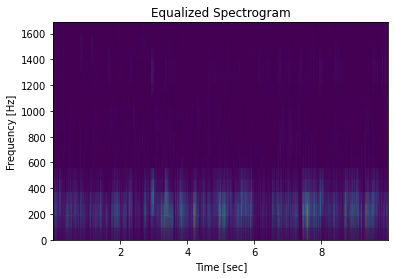

In [9]:
# simulate fixed point filters
if (write_audio_files_fixed == True) :
    # get audio
    audio, fs = sf.read('fahey.wav')
    audio_snipped = audio[fs*5:fs*(5+audio_length_sec)]
    x = audio_snipped[:,0]
    equalized_x = np.zeros(np.shape(x))
    
    # convert ADC to word-aligned int
    x_fixed = [int(2**(adc_bit_length-1) * i) for i in x]
    x_float = [(i / 2**(adc_bit_length-1)) for i in x_fixed]
    sf.write("quantized.wav", x_float, fs)

    # iterate through filters to simulate equalizer
    for index in range(filter_count):
        taps = filter_taps_fixed[index]
        
        # filter individual channels
        filtered_audio = np.convolve(x_fixed, taps, mode='full') / filter_amp_fixed[index]
        
        # add to equalized audio channel
        equalized_x = equalized_x + filtered_audio[:len(equalized_x)]
        
        # write filtered audio to wav file
        file_name = "filtered_audio_fixed{}.wav".format(index+1)
        unquantized = [(i / 2**(adc_bit_length-1)) for i in filtered_audio]
        audio_out = [[i, i] for i in unquantized]
        sf.write(file_name, audio_out, fs)
        
        # plot frequency contents
        f, t, Sxx = signal.spectrogram(np.array(filtered_audio), fs)
        plt.pcolormesh(t, f[:10], Sxx[:10], shading='gouraud')
        plt.title("Filter{} Spectrogram".format(index+1))
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
        
    # write out equalized input audio
    unquantized = [(i / 2**(adc_bit_length-1)) for i in equalized_x]
    audio_out = [[i, i] for i in unquantized]
    sf.write("equalized_audio_fixed.wav", audio_out, fs)
    
    # plot frequency contents
    f, t, Sxx = signal.spectrogram(equalized_x, fs)
    plt.pcolormesh(t, f[:10], Sxx[:10], shading='gouraud')
    plt.title("Equalized Spectrogram")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()   

## Write filter coefficients to VHDL

In [10]:
# Constant strings
indent_after_element = 10
file_path = "../Source/filter_taps_pkg.vhd"
header = '''----------------------------------------------------------------------------------
-- FILENAME: filter_taps_pkg.vhd
--
-- DESCRIPTION: Autogenerated filter taps
----------------------------------------------------------------------------------

library ieee;
use ieee.std_logic_1164.all;
use ieee.numeric_std.all;
use ieee.math_real.all;

use work.user_pkg.all;

package filter_taps_pkg is

'''
types = "\t-- Types\n"
define = "\t-- Define\n"
declare = "\tconstant FILTER_TAPS : TAPS_ARR := (\n"
file_end = '''
end filter_taps_pkg;
'''

# Parameters
array_type = "\ttype TAPS_ARR is array (0 to FILTER_COUNT-1, 0 to FIFO_OUT_DEPTH-1) of integer;\n\n"

In [11]:
# Open file
file = open(file_path, "w")

# Write to file
file.write(header)
file.write(types)
file.write(array_type)
file.write(define)
file.write(declare)
for i in range(filter_count) :
    file.write("\t\t(")
    for j in range(int(filter_sizes[i] / 2) + 1) :
        value = filter_taps_fixed[i][j]
        file.write(str(value))
        if (j != int(filter_sizes[i] / 2)) :
            file.write(", ")
        if ((j+1) % indent_after_element == 0) :
            file.write("\n\t\t")
    if (i != (filter_count - 1)) :
        file.write("), -- end of filter {}\n".format(i+1))
    else :
        file.write(") -- end of filter {}\n".format(i+1))
        
file.write("\t);\n")
file.write(file_end)

# Close file
file.close()